<a href="https://colab.research.google.com/github/FrancescoMalaspina/NLP_project_DeepLearningClass/blob/main/DeepLearning_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle fake news competition
The objective of my project is performing a simple NLP task: text classification. In particular it consisted in building a system capable of classifying articles in **fake** or **reliable** news, based on the *text*, the *title*, and the *author*.

The dataset I used is part of a 'getting started' kaggle competion, which is described at [this link](https://www.kaggle.com/competitions/fake-news/overview).

## kaggle setup
Here below I'm setting up the environment with the API token from my kaggle account, in order to be able to download the dataset. Then I'm using kaggle competitions API to download it and unzip it.

In [ ]:
from google.colab import files
! pip install -q kaggle
files.upload() # upload kaggle API token for identification
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

Saving kaggle.json to kaggle.json


In [ ]:
#! kaggle competitions download -c nlp-getting-started
! kaggle competitions download -c fake-news
! unzip fake-news.zip  > /dev/null 2>&1
! ls

 90% 42.0M/46.5M [00:00<00:00, 141MB/s]
100% 46.5M/46.5M [00:00<00:00, 132MB/s]
fake-news.zip  kaggle.json  sample_data  submit.csv  test.csv  train.csv


The next step is importing the general libraries (`pandas`, `numpy`, `tensorflow`, and `matplotlib`) that I will use in the project and reading the `csv` file containing the dataset. I will need a few other specific modules later on, but I will import them when needed, to make things more clear.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(7)

df = pd.read_csv('train.csv')

# create new col: news = title + text
# this also deals with null values.
df['news'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df.head(5)

,id,title,author,text,label,news
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


# Dataset preparation
Once the dataset is loaded in memory it needs to be prepared for NLP. So I first performed a brief exploratory data analysis, to decide how to continue.
Then I **cleaned** it, **tokenized** it, and created an **embedding** using a pretrained `word2vec` model, taken from the library `gensim` (the fake news dataset was not big enough to obtain a reliable embedding from scratch).

## Text Cleaning
The text was cleaned with these operations:
 - removed urls, html text, punctuation
 - the most common stopwords that don't change the meaning were removed, using the library nltk
 - lemmatization (?) maybe it is not necessary

In [ ]:
import re     # for regular expression support
import nltk   # for standard text-processing tasks
nltk.download('stopwords')
from nltk.corpus import stopwords

# some helper functions for pre-processing the text
def remove_urls(text):
    """For removing urls"""
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    """For removing html text"""
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def punct_remove(text):
    """For removing punctuations"""
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def remove_stopwords(text):
    """For removing stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# for cleaning or pre-processing the text
def clean_text(text):

    # remove urls
    new_text = remove_urls(text)

    # remove html text
    new_text = remove_html(new_text)

    # remove punctuations
    new_text = punct_remove(new_text)

    # lower casing the text
    new_text = new_text.strip().lower()

    # remove stop words
    new_text = remove_stopwords(new_text)

    return new_text

# clean news text
df['news'] = df['news'].apply(lambda x: clean_text(x))
df.head()

# maximum length of a sentence in the corpus
max_len = (df['news'].apply(lambda x: len(x.split(' ')))).max()
print('Max length of a sentence in the corpus: ' + str(max_len))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Max length of a sentence in the corpus: 20731


,id,title,author,text,label,news
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitba...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilians killed single us airstrike identi...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,rapper ti trump poster child white supremacy r...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,nfl playoffs schedule matchups odds new york t...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,macys said receive takeover approach hudsons b...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,nato russia hold parallel exercises balkans na...


## Tokenization

In [ ]:
# create a new column with the tokenized text
df['tokens'] = df['news'].str.split()
#df = df[['author', 'label', 'tokens']]
df['tokens']

0        [house, dem, aide, didnt, even, see, comeys, l...
1        [flynn, hillary, clinton, big, woman, campus, ...
2        [truth, might, get, fired, truth, might, get, ...
3        [15, civilians, killed, single, us, airstrike,...
4        [iranian, woman, jailed, fictional, unpublishe...
                               ...                        
20795    [rapper, ti, trump, poster, child, white, supr...
20796    [nfl, playoffs, schedule, matchups, odds, new,...
20797    [macys, said, receive, takeover, approach, hud...
20798    [nato, russia, hold, parallel, exercises, balk...
20799    [keeps, f35, alive, david, swanson, author, ac...
Name: tokens, Length: 20800, dtype: object

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models import Word2Vec

# lemmatize the words
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
del lemmatizer
#df['tokens']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Embedding: gensim pretrained word2vec
At this moment I have transformed the each element in the dataset in a list of *lemmatized* words, and I have eliminated all punctuation or special character. (there is also the label, but I'm talking about the text features)

The next step is creating a way to represent those words, in order to be able to feed them to a classification model.

A really effective way is to **embed** them, using a `word2vec` model. This allow to represent them in a way that already takes into account the similarity between words, according to them appearing in similar contexts.

To do this I used the library `gensim` which provides a standard implementation of the `word2vec` model, but also a set of pretrained models. I choose to use one of those, since my dataset was not big enough to obtain a meaningful embedding (I tried).

I choose the `glove-wiki-gigaword-100` model, which embeds words in a 100 dimensional feature space, and was trained on the wikipedia and gigaword datasets.

In [ ]:
import gensim.downloader as api
# download the pretrained embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")
#cn_vectors = api.load("conceptnet-numberbatch-17-06-300")
#pre_ft_vectors = api.load('fasttext-wiki-news-subwords-300')

[=================================================-] 99.0% 126.8/128.1MB downloaded


### Info on the available models
Here is a brief description of all available models.

In [ ]:
info = api.info()

# check the available pretrained models
for model_name, model_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description'][:] + '...',
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors of the movie matrix....
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting....
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)....
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,

### gensim word2vec Encoding
To encode the text I encoded each word in each sentence using gensim' model, and then I had 2 options:
 - pad each sentence with zeros to match the max lenght of sentences in the dataset. In this way I would obtain a tensor of shape (dataset len, max sentence len, num of encoding features) = (20 000, 20 000, 100). In total 40 billions floats, the ram of colab can't hold it.
 - average the encoding of each sentence
I choose the second, due to the unfeasibility of the first.

I found I turnaround for this problem later on, but I worked really hard for this function and I really like the result so I kept for the first simple 'reference' model.

In [ ]:
# Load a pre-trained word2vec model
w2v_model = glove_vectors

# Index2word is a list that contains the names of the words in
# the model's vocabulary. Convert it to a set, for speed
index2word_set = set(w2v_model.wv.index2word)

def encode_text(tokens, model = w2v_model, num_features = 100):
    # Initialize an empty numpy array (for speed)
    features = np.zeros((num_features,), dtype="float32")

    # number of words in the sentence
    nwords = 0

    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for token in tokens:
        if token in index2word_set:
            nwords += 1
            features = np.add(features, model[token])
    # Divide the result by the number of words to get the average
    if nwords == 0:
        nwords = 1
    features = np.divide(features, nwords)
    return features

df['encoding'] = df['tokens'].apply(lambda x: encode_text(x))
del(index2word_set, w2v_model)

<ipython-input-12-71f97370e976>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  index2word_set = set(w2v_model.wv.index2word)


### tf tensors dataset
Finally here below I converted the data to tf tensors, in order to be able to feed them to a neural network.

The pandas dataframe column `encoding` was a pandas Series of numpy arrays. I turned it into an array of arrays by accessing the `values` property, then to a `np.ndarray` (2 dimensional array) with `np.vstack`, and finally to a tf tensor with `tf.convert_to_tensor`.  

For the y values I choose to one-hot encode the values. In this case it would not be necessary, being a binary classification problem. I did anyway so that this approach could be generalized, for example to the case of text classification of articles in base of their topic.

In [ ]:
from keras.utils.np_utils import to_categorical

X = tf.convert_to_tensor( np.vstack(df.encoding.values))
#df = df[['author', 'label', 'tokens']]

X_train, X_test = X[:19000], X[19000:]
X_train.shape

# one hot encoding the labels
y = tf.convert_to_tensor( to_categorical(df.label))
y_train, y_test = y[:19000], y[19000:]
X.shape

TensorShape([20800, 100])

## Recap
At first I:
 - imported the data
 - cleaned them (lower case, special characters removed)
 - removed the stopwords
 - tokenized the remaining text

Then I loaded a pretrained word2vec model, taken from the library gensim and applied it to our data. We obtanied an encoding of each word in a feature vectore of dimension 100.

# Deep Learning part
Now I finally can train a neural network on this encoding, to classify the news in fake or reliable.

I tried 3 types of neural networks:
 - MLP: fully connected NN, with ReLU, Adam, softmax. Hidden neurons? maybe 256, 256. Or 128, 128, 128.
 - 1D CNN.
 - RNN (this is more tricky).

# Multi Layer Perceptron - base model
The first model I implemented is a simple Feed-Forward Neural Network, with 2 fully connected layers. The features are just the average word2vec embedding of the various articles.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

mlp = Sequential([
    Dense(128, activation = 'relu', input_dim = 100),
    Dense(128, activation = 'relu'),
    Dense(2, activation='softmax')
])

mlp.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               12928     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
Total params: 29,698
Trainable params: 29,698
Non-trainable params: 0
_________________________________________________________________


final train accuracy: 0.9774736762046814
final test accuracy: 0.8972222208976746


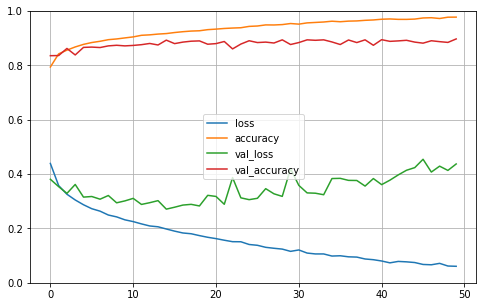

In [ ]:
history = mlp.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), verbose = 0)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

print('final train accuracy: {0}\nfinal test accuracy: {1}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
del (mlp, history)

# CNN with word2vec
The second model I tried is a 1D convolutional neural network. I treated each element of the embedding vector as an independent feature, and I tried to exploit the topology present in the sequence of words in a sentence with the convolutions.

I am not sure that the hypothesis of independence in the features is actually the case, but empirically it seems to work well. It also makes more sense than using 2D convolutions, since in every case the topolgy in the embedding space would be much different than the one in a sentence.

## embedding layer
As mentioned before, I found a turnaround to use the embeddings of (almost) the entire sentences, without exceeding the RAM or having to load the dataset from disk during training.

I used keras Tokenizer class to **encode** each word into an integer and padding the resulting sentences with 0 to obtain sequences of the same length.

Then I used `gensim` function `get_keras_embedding` to generate **embeddings** on the fly, direclty inside keras `Sequential()` model.

The main problem with this was making so that the same encoding word-integer was used by keras and gensim. To do it I extracted the vocabulary of the trained gensim model, which is very big and general, and told keras Tokenizer to use it.

In [ ]:
word2vec_model = glove_vectors
#print(word2vec_model.vectors.shape)
#word2vec_model = Word2Vec(df['tokens'], size=100, window=5, min_count=1, workers=4)
#word2vec_model.wv

vocabulary = {word: vector.index for word, vector in word2vec_model.vocab.items()}
num_words = len(vocabulary)

# check if it works
word2vec_model.most_similar('house')
#num_words

[('office', 0.7581614851951599),
 ('senate', 0.7204986214637756),
 ('room', 0.7149738669395447),
 ('houses', 0.6888046264648438),
 ('capitol', 0.6851760149002075),
 ('building', 0.684728741645813),
 ('home', 0.6720309257507324),
 ('clinton', 0.6707026362419128),
 ('congressional', 0.6692575812339783),
 ('mansion', 0.665092408657074)]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Input, Dense

# tokenizing the text
tk = Tokenizer(num_words=len(vocabulary))
tk.word_index = vocabulary
X = tk.texts_to_sequences(df.tokens.values)
print(tk.texts_to_sequences(['house','job']))
print(vocabulary['house'])

# Adding 1 because of reserved 0 index
vocab_size = len(tk.word_index) + 1
max_len = 5000

# padding sequences with zeroes
X = pad_sequences(X, padding = 'post', maxlen = max_len)

# note only 20 articles have more than 5000 words, so I'm truncating them at this value
print('shape of data where the articles have more than 5000 words: ', df[df.tokens.apply(lambda x: len(x)) > 5000].shape)

# train-test split
X_train, X_test = X[:19000], X[19000:]
del(X)

y = tf.convert_to_tensor( to_categorical(df.label))
y_train, y_test = y[:19000], y[19000:]
del(y)

[[166], [664]]
166
shape of data where the articles have more than 5000 words:  (20, 5)


## Network construction

In [ ]:
tf.random.set_seed(7)

cnn = Sequential([
    Input(shape = (5000,)),
    word2vec_model.get_keras_embedding(train_embeddings = False),
    Dropout(0.2),
    Conv1D(32, 3, activation='relu', padding='same', strides=1),
    Conv1D(32, 3, activation='relu', padding='same', strides=1),
    MaxPool1D(),
    Dropout(0.2),
    Conv1D(64, 3, activation='relu', padding='same', strides=1),
    Conv1D(64, 3, activation='relu', padding='same', strides=1),
    MaxPool1D(),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu', padding='same', strides=1),
    Conv1D(128, 3, activation='relu', padding='same', strides=1),
    GlobalMaxPool1D(),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')
])

cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5000, 100)         40000000  
                                                                 
 dropout_25 (Dropout)        (None, 5000, 100)         0         
                                                                 
 conv1d_30 (Conv1D)          (None, 5000, 32)          9632      
                                                                 
 conv1d_31 (Conv1D)          (None, 5000, 32)          3104      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2500, 32)         0         
 g1D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 2500, 32)          0         
                                                      

<ipython-input-51-fbf27367192a>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word2vec_model.wv.get_keras_embedding(train_embeddings = False),


Non-trainable params: 40,000,000
_________________________________________________________________


## Training

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.6059
Epoch 1: val_loss improved from inf to 0.53506, saving model to model.weights.best.hdf5
75/75 [==============================] - 22s 287ms/step - loss: 0.6370 - accuracy: 0.6059 - val_loss: 0.5351 - val_accuracy: 0.7483
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8549
Epoch 2: val_loss improved from 0.53506 to 0.20597, saving model to model.weights.best.hdf5
75/75 [==============================] - 22s 295ms/step - loss: 0.3373 - accuracy: 0.8549 - val_loss: 0.2060 - val_accuracy: 0.9300
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9248
Epoch 3: val_loss improved from 0.20597 to 0.14936, saving model to model.weights.best.hdf5
75/75 [==============================] - 21s 283ms/step - loss: 0.2009 - accuracy: 0.9248 - val_loss: 0.1494 - val_accuracy: 0.9444
Epoch 4/25
75/75 [==============================] 

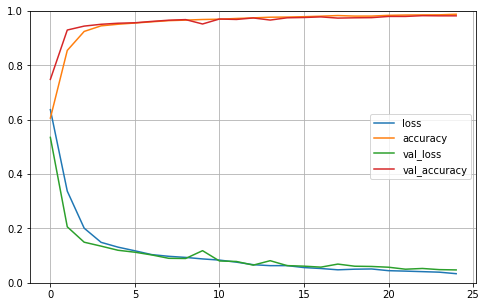

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
batch_size = 256 #@param {type:"integer"}
epochs = 25 #@param {type:"integer"}

tf.random.set_seed(7)

history = cnn.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks =[checkpointer]
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

print('final train accuracy: {0}\nfinal test accuracy: {1}'.format(np.array(history.history['accuracy']).max(), np.array(history.history['val_accuracy']).max()))
del cnn, checkpointer, history

# CNN with trainable embedding
Here I tried not to use the word2vec embedding, but keras `Embedding()` layer. This means that also the feature extraction was performed, and trained, by the network itself.
The resulting network was huge, in the number of parameters, but surprasingly fast to train (even faster than the previous case). This could be due mostly to keras underhood optimization of its layers, so that **training** this Embedding layer is way faster than **computing** gensim enbeddings on the fly.

The results are pretty good, but the bigger number of parameters makes it so that there is some overfitting (totally absent before). In fact the **train accuracy** almost reaches 100% but the **test accuracy** gets stuck at 98%.

## Network construction

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Input, Dense
from keras.layers import Embedding

tf.random.set_seed(7)

cnn = Sequential([
    Input(shape = (max_len,)),
    Embedding(input_dim = vocab_size, output_dim = 16, input_length=max_len, trainable = True),
    Dropout(0.3),
    Conv1D(32, 3, activation='relu', padding='same', strides=1),
    Conv1D(32, 3, activation='relu', padding='same', strides=1),
    MaxPool1D(),
    Dropout(0.2),
    Conv1D(64, 3, activation='relu', padding='same', strides=1),
    Conv1D(64, 3, activation='relu', padding='same', strides=1),
    MaxPool1D(),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu', padding='same', strides=1),
    Conv1D(128, 3, activation='relu', padding='same', strides=1),
    GlobalMaxPool1D(),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')
])

cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 5000, 16)          6400016   
                                                                 
 dropout_30 (Dropout)        (None, 5000, 16)          0         
                                                                 
 conv1d_36 (Conv1D)          (None, 5000, 32)          1568      
                                                                 
 conv1d_37 (Conv1D)          (None, 5000, 32)          3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2500, 32)         0         
 g1D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 2500, 32)          0         
                                                      

## Training

Epoch 1/15
149/149 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.7929
Epoch 1: val_loss improved from inf to 0.08378, saving model to model.weights.best.hdf5
149/149 [==============================] - 19s 120ms/step - loss: 0.3846 - accuracy: 0.7929 - val_loss: 0.0838 - val_accuracy: 0.9728
Epoch 2/15
149/149 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9723
Epoch 2: val_loss improved from 0.08378 to 0.06721, saving model to model.weights.best.hdf5
149/149 [==============================] - 18s 120ms/step - loss: 0.0862 - accuracy: 0.9723 - val_loss: 0.0672 - val_accuracy: 0.9811
Epoch 3/15
149/149 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9886
Epoch 3: val_loss improved from 0.06721 to 0.06464, saving model to model.weights.best.hdf5
149/149 [==============================] - 18s 123ms/step - loss: 0.0354 - accuracy: 0.9886 - val_loss: 0.0646 - val_accuracy: 0.9811
Epoch 4/15
149/149 [==================

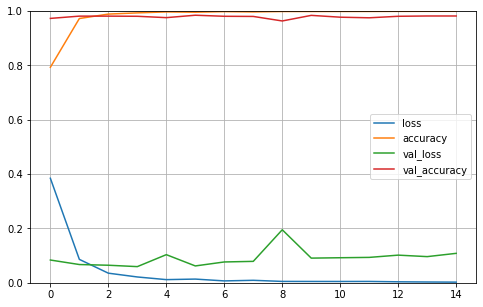

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
batch_size = 128 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}
tf.random.set_seed(7)

history = cnn.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks =[checkpointer]
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

print('final train accuracy: {0}\nfinal test accuracy: {1}'.format(np.array(history.history['accuracy']).max(), np.array(history.history['val_accuracy']).max()))
del cnn, checkpointer, history

# RNN with gensim word2vec
Next I'm trying with RNN, in particular using LSTM cells. The data preparation is the same as for CNNs, but I'm cutting sequences at 1024 words, rather than at 5000, otherwise the training is too slow.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Input, Dense, LSTM, Bidirectional

# defining a common vocabulary for gensim and keras
word2vec_model = glove_vectors
vocabulary = {word: vector.index for word, vector in word2vec_model.vocab.items()}
num_words = len(vocabulary)

# tokenizing the text
tk = Tokenizer(num_words=len(vocabulary))
tk.word_index = vocabulary
X = tk.texts_to_sequences(df.tokens.values)
#max_len = df.tokens.apply(lambda x: len(x)).max()
max_len = 1024

# padding sequences with zeroes
X = pad_sequences(X, padding = 'post', maxlen = max_len)

# train-test split
X_train, X_test = X[:19000], X[19000:]
del(X)

y = tf.convert_to_tensor( to_categorical(df.label))
y_train, y_test = y[:19000], y[19000:]
del(y)

## Network construction

In [ ]:
rnn = tf.keras.Sequential([
    Input(shape = (max_len,)),
    word2vec_model.get_keras_embedding(),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')
])

rnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 100)         40000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024, 256)        234496    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)              

## Training

Epoch 1/15
75/75 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8494
Epoch 1: val_loss improved from inf to 0.19803, saving model to model.weights.best.hdf5
75/75 [==============================] - 35s 402ms/step - loss: 0.3286 - accuracy: 0.8494 - val_loss: 0.1980 - val_accuracy: 0.9078
Epoch 2/15
75/75 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9381
Epoch 2: val_loss improved from 0.19803 to 0.14637, saving model to model.weights.best.hdf5
75/75 [==============================] - 29s 387ms/step - loss: 0.1541 - accuracy: 0.9381 - val_loss: 0.1464 - val_accuracy: 0.9367
Epoch 3/15
75/75 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9582
Epoch 3: val_loss improved from 0.14637 to 0.13813, saving model to model.weights.best.hdf5
75/75 [==============================] - 29s 383ms/step - loss: 0.1086 - accuracy: 0.9582 - val_loss: 0.1381 - val_accuracy: 0.9472
Epoch 4/15
75/75 [==============================] 

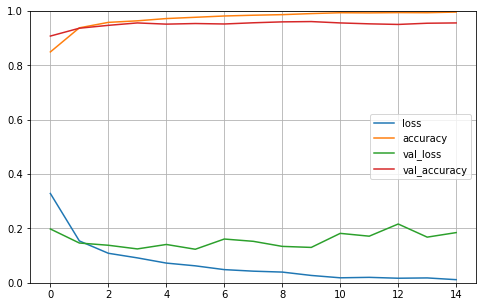

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
batch_size = 256 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}

tf.random.set_seed(7)

history = rnn.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks =[checkpointer]
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

print('final train accuracy: {0}\nfinal test accuracy: {1}'.format(np.array(history.history['accuracy']).max(), np.array(history.history['val_accuracy']).max()))
del rnn, checkpointer, history

# RNN with trainable embedding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tf.random.set_seed(7)

# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.tokens)
X = tokenizer.texts_to_sequences(df.tokens.values)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
max_len = 1000

# padding sequences with zeroes
X = pad_sequences(X, padding = 'post', maxlen = max_len)

# train-test split
X_train, X_test = X[:19000], X[19000:]
X_train.shape

y = tf.convert_to_tensor( to_categorical(df.label))
y_train, y_test = y[:19000], y[19000:]
del(X,y)

## Network construction

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Input, Dense
from keras.layers import Embedding, LSTM, Bidirectional

tf.random.set_seed(7)

rnn = tf.keras.Sequential([
    Input(shape = (max_len,)),
    Embedding(input_dim = vocab_size, output_dim = 16, input_length = max_len, trainable = True),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(2, activation = 'softmax')
])

rnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 16)          3200880   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

## Training

Epoch 1/15
149/149 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8742
Epoch 1: val_loss improved from inf to 0.11165, saving model to model.weights.best.hdf5
149/149 [==============================] - 21s 93ms/step - loss: 0.2723 - accuracy: 0.8742 - val_loss: 0.1117 - val_accuracy: 0.9528
Epoch 2/15
149/149 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9887
Epoch 2: val_loss did not improve from 0.11165
149/149 [==============================] - 13s 89ms/step - loss: 0.0345 - accuracy: 0.9887 - val_loss: 0.1119 - val_accuracy: 0.9622
Epoch 3/15
149/149 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9981
Epoch 3: val_loss did not improve from 0.11165
149/149 [==============================] - 13s 89ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.1733 - val_accuracy: 0.9528
Epoch 4/15
149/149 [==============================] - ETA: 0s - loss: 6.7002e-04 - accuracy: 0.9998
Epoch 4: val_loss did not impro

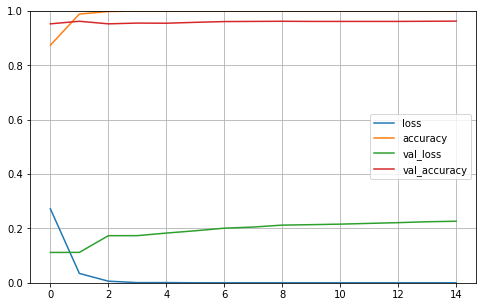

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
batch_size = 128 #@param {type:"integer"}
epochs = 15 #@param {type:"integer"}

tf.random.set_seed(7)

history = rnn.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks =[checkpointer]
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

print('final train accuracy: {0}\nfinal test accuracy: {1}'.format(np.array(history.history['accuracy']).max(), np.array(history.history['val_accuracy']).max()))
del rnn, checkpointer, history

# Why CNN perform better than RNN in this task?

Here is a summary of the performances of the different architectures I implemented.

|Model |Train Accuracy |Test Accuracy |Number of paramters|
|------|---------------|--------------|--|
|MLP       |0.9774 |0.8972 |29,698|
|CNN + w2v |0.9880 |**0.9844** |122,050|
|CNN + Emb |0.9989 |0.9816 |6,514,002|
|RNN + w2v |0.9961 |**0.9611** |498,178|
|RNN + Emb |1.0000 |0.9628 |3,259,122|

It is clear that the CNN is best one, in terms of performance. Not only it reaches 98.5% **test accuracy**, but also it avoids incredibly well overfitting.

Almost all other architectures approach 1.0 **train accuracy** but fall shorter in the other one, meaning that they are learning the noise in the train dataset. The CNN is not.

Obviously when I train also the embedding I add a ton of degree of freedoms, so the model inevitably learns the noise, but the test performance does not suffer from this.

### My explanation
In my opinion, this could be due to fact that a RNN focus also on learning the structure of the text. The CNN instead focus only on recognizing the patterns of fake news.

We don't care about where the fake news is in the article or how it is formulated, just that it's there. This is why convolutional filters can be so effective in identifying the fake news, while the RNNs get somewhat 'distracted' and can be more effective for other tasks. Maybe an attention mechanism could improve the RNNs, but it would start to complicate things a lot, and it is not necessary, since the CNN is working so well.



# Author reliability
I want to add a feature, that I call author reliability, and see if it improves this result, before passing to more complex models.

For each author I will compute the ratio of reliable news, and I will assign to each article this value.

In [ ]:
df1 = pd.DataFrame()
df.author.fillna('missing', inplace = True)
df1['author_reliability'] = df.groupby('author')['label'].mean()*2 - 1
df1['num_of_art'] = df.groupby('author')['label'].count()
df1.sort_values('num_of_art', ascending = False).head(20)
df2 = pd.merge(df, df1, how = 'outer', on = 'author')
#df2[df2.author_reliability==-1]
df2['classification'] = np.where(df2.author_reliability < 0 , 0, 1)
inc = df2[df2['classification'] != df2['label']].shape[0]
tot = df2.shape[0]
print('accuracy considering only an author based classification: ',1-inc/tot)

accuracy considering only an author based classification:  0.9982692307692308


In [ ]:
X_np = np.vstack(df.encoding.values)

X_np = np.hstack((X_np[:,:], df2.author_reliability.values[np.newaxis, :].T))#, df2.num_of_art.values[np.newaxis, :].T))
#X_np = (df2.author_reliability.values[np.newaxis, :].T)

X = tf.convert_to_tensor(X_np)

X_train, X_test = X[:19000], X[19000:]
#X_train.shape

Epoch 1/30
594/594 [==============================] - 2s 3ms/step - loss: 0.3894 - accuracy: 0.8263 - val_loss: 0.3305 - val_accuracy: 0.8589
Epoch 2/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2995 - accuracy: 0.8735 - val_loss: 0.3113 - val_accuracy: 0.8700
Epoch 3/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2673 - accuracy: 0.8877 - val_loss: 0.2919 - val_accuracy: 0.8722
Epoch 4/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2460 - accuracy: 0.9003 - val_loss: 0.2846 - val_accuracy: 0.8822
Epoch 5/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2264 - accuracy: 0.9076 - val_loss: 0.2725 - val_accuracy: 0.8794
Epoch 6/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2122 - accuracy: 0.9153 - val_loss: 0.2753 - val_accuracy: 0.8822
Epoch 7/30
594/594 [==============================] - 2s 3ms/step - loss: 0.2006 - accuracy: 0.9197 - val_loss: 0.2910 - val_accuracy: 0.8833
Epoch 

(0.0, 1.0)

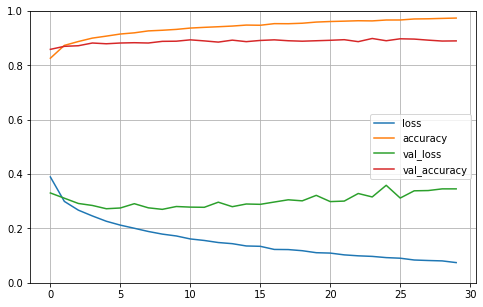

In [ ]:
from keras.layers import Normalization, Dense, Input
from keras.models import Sequential
norm = Normalization()
norm.adapt(X)

mlp_with_author = Sequential([
    Input(101),
    norm,
    #Dense(16, activation = 'relu'),
    #Dropout(0.2),
    Dense(128, activation = 'relu'),
    #Dropout(0.2),
    Dense(2, activation='softmax')
])

mlp_with_author.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#mlp_with_author.summary()
history = mlp_with_author.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test), verbose = 1)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

# What remains to be done
 - analyze the items that are not correctly classified in the training set, to understand how and why they are eluding my models.
    - Is a matter of a not so good text cleaning? (maybe it resulted in meaningless words, or useful words were deleted).
    - Or instead the embedding and classification got biased in some way?
    - does the cut at 5000 sentence length have an impact?
 - understand why the *author reliability* feature doesn't improve my model.
 - We could also try with an autoencoder for anomaly detection, training only on reliable news (in the real world we have tons of it). Or also we could train one on reliable and one on fake, and then make them vote.
    - Interesting question: how would this network reconstruct a fake news as a real one?

## Final remark
What does separate a reliable news from a fake one? I tried to read a few (of both), and I could not clearly classify any of them. It is a very tricky task, even for humans! Apparently my model is doing much better than me, but it's not telling me how!